# Cross-Validation 

In [1]:
import os
import sys
# Here you need to have same Python version on your local machine adn on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [ ]:
# Run this cell if you are using sklearn for the first time
# ! pip3 install sklearn --user

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Regularization').getOrCreate()

22/04/25 14:12:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from sklearn.datasets import load_diabetes
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['y'] = diabetes.target
sdf = spark.createDataFrame(df)

assembler = VectorAssembler(inputCols=[c for c in sdf.columns if c != 'y'],
                            outputCol='features')
dataset = assembler.transform(sdf)
dataset.show(5)

[Stage 0:>                                                          (0 + 1) / 1]

+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|                 age|               sex|                bmi|                  bp|                  s1|                 s2|                 s3|                  s4|                 s5|                 s6|    y|            features|
+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-----+--------------------+
|  0.0380759064334241|0.0506801187398187| 0.0616962065186885|  0.0218723549949558| -0.0442234984244464|-0.0348207628376986|-0.0434008456520269|-0.00259226199818282| 0.0199084208763183|-0.0176461251598052|151.0|[0.03807590643342...|
|-0.00188201652779104|-0.044641636506989|-0.0514740612388061| -0.0263278

## We haven't tested models on unseen data!

In [5]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)


In [8]:
train, test = dataset.randomSplit([0.5, 0.5], 25)
lr = LinearRegression(featuresCol='features', labelCol='y')
model = lr.fit(train)

# Evaluate on training data
summary_train = model.evaluate(train)
print('R2 (training): ', summary_train.r2)

# Evaluate on training data
summary_test = model.evaluate(test)
print('R2 (testing): ', summary_test.r2)

22/04/25 14:14:21 WARN Instrumentation: [a1487062] regParam is zero, which might cause numerical instability and overfitting.


R2 (training):  0.5181900476715522
R2 (testing):  0.4877744155729147


## Increase training fraction?

In [13]:
# We specify this so that the train and test data set always have the same rows, respectively
 np.random.seed(3)

IndentationError: unexpected indent (3010978141.py, line 2)

22/04/25 14:15:23 WARN Instrumentation: [410bccb5] regParam is zero, which might cause numerical instability and overfitting.
22/04/25 14:15:24 WARN Instrumentation: [3e4b5209] regParam is zero, which might cause numerical instability and overfitting.
22/04/25 14:15:25 WARN Instrumentation: [22e7f8ac] regParam is zero, which might cause numerical instability and overfitting.
22/04/25 14:15:27 WARN Instrumentation: [8231e1c1] regParam is zero, which might cause numerical instability and overfitting.


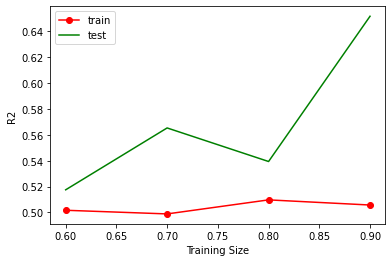

In [15]:
p_train = [0.6, 0.7, 0.8, 0.9]
train_r2 = []
test_r2 = []

for p in p_train:
    train, test = dataset.randomSplit([p, 1 - p], 25)
    model = lr.fit(train)
    
    # Evaluate on training data
    summary_train = model.evaluate(train)
    train_r2.append(summary_train.r2)

    # Evaluate on training data
    summary_test = model.evaluate(test)
    test_r2.append(summary_test.r2)

plt.plot(p_train, train_r2, 'ro-', label='train')
plt.plot(p_train, test_r2, 'g', label='test')
plt.xlabel('Training Size')
plt.ylabel('R2')
plt.legend()